In [30]:
import tensorflow as tf
from tensorflow import keras
print("Number of GPUS : ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Number of GPUS :  1


True

In [31]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from tqdm import tqdm

In [32]:
import glob
import cv2

In [33]:

x_train = []
y_train = []
x_test = []
y_test = []
# val=[]


for images in tqdm(glob.iglob(f'../trainingdata/*')):
    print(images)
    break
    label = fun(images)
    x_train.append(cv2.imread(images, 0))
    y_train.append(label)

0it [00:00, ?it/s]

../trainingdata\normal


In [34]:
vgg = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

In [35]:
for layer in vgg.layers:
    layer.trainable = False

In [36]:
x = Flatten()(vgg.output)

In [37]:
folders = glob.glob('../over/*')

In [38]:
print(len(folders))

2


In [39]:
from keras.layers import Conv2D, Dropout

In [40]:
model = Sequential()

for layer in vgg.layers:
    model.add(layer)
    

model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='additional_layer') )

model.add(Flatten())
model.add(Dense(2, activation='softmax', name='predictions'))

In [41]:
es=EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    verbose=1,
    mode=min
)

In [45]:
# prediction = Dense(len(folders), activation='softmax')(x)

# model = Model(vgg.inputs, output='predictions')

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [43]:
optimizer = keras.optimizers.Adam(lr=0.00001)

c:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [45]:
train_path = '../over'
test_path = '../dataset/chest_xray/test'

In [46]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 7750 images belonging to 2 classes.


In [47]:
training_set.class_indices

{'normal': 0, 'pneumonia': 1}

In [48]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical', 
                                            shuffle=False)

Found 624 images belonging to 2 classes.


In [49]:
r = model.fit(training_set,validation_data=test_set,epochs=100,steps_per_epoch=len(training_set),validation_steps=len(test_set),callbacks=[es])

Epoch 1/100
243/243 [==============================] - 134s 536ms/step - loss: 0.5584 - accuracy: 0.7225 - val_loss: 0.4629 - val_accuracy: 0.8429
Epoch 2/100
243/243 [==============================] - 109s 446ms/step - loss: 0.3500 - accuracy: 0.8710 - val_loss: 0.3592 - val_accuracy: 0.8590
Epoch 3/100
243/243 [==============================] - 110s 453ms/step - loss: 0.2672 - accuracy: 0.9048 - val_loss: 0.3207 - val_accuracy: 0.8606
Epoch 4/100
243/243 [==============================] - 115s 472ms/step - loss: 0.2251 - accuracy: 0.9178 - val_loss: 0.2987 - val_accuracy: 0.8750
Epoch 5/100
243/243 [==============================] - 114s 469ms/step - loss: 0.2038 - accuracy: 0.9246 - val_loss: 0.2870 - val_accuracy: 0.8782
Epoch 6/100
243/243 [==============================] - 113s 466ms/step - loss: 0.1940 - accuracy: 0.9277 - val_loss: 0.2748 - val_accuracy: 0.8846
Epoch 7/100
243/243 [==============================] - 116s 475ms/step - loss: 0.1854 - accuracy: 0.9321 - val_loss: 0

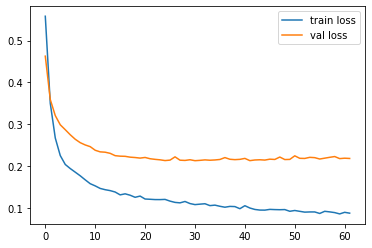

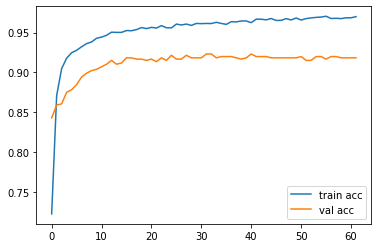

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
Y_pred = model.predict_generator(test_set, verbose = True)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = list(training_set.class_indices.keys())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

C:\Users\SAKSHAM\AppData\Local\Temp\ipykernel_15988\9868999.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_set, verbose = True)


20/20 [==============================] - 7s 302ms/step
Confusion Matrix
[[204  30]
 [ 21 369]]
Classification Report
              precision    recall  f1-score   support

      normal       0.91      0.87      0.89       234
   pneumonia       0.92      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624

